<a href="https://colab.research.google.com/github/sancarhacer/MachineLearning/blob/main/24_HDBScanDBScan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

👉 **HDBSCAN**, bu sabit yoğunluk varsayımını **kaldırır**.  
Yani: “**Yoğun yerleri ayrı kümeler** olarak tanır, **seyrek yerleri ayırır.**”  
Bunu yaparken **yoğunluğa göre değişen bir mesafe ölçüsü** ve **hiyerarşik (katmanlı)** bir yapı kurar.

---

### 🔹 1. Mutual Reachability Distance (Ortak Erişim Mesafesi)

Bu, HDBSCAN’in kalbidir.  
İki nokta arasındaki gerçek mesafe `d(a,b)` değil de şu şekilde ölçülür:

\[
d_{mreach-k}(a,b) = \max(\text{core}_k(a), \text{core}_k(b), d(a,b))
\]

**Nedir bunlar?**

- `core_k(a)`: Nokta **a**’nın **k tane en yakın komşusuna** olan mesafesi  
  → Noktanın bulunduğu yerin **yoğunluğunu** temsil eder.  
  (Küçükse, etrafı yoğundur.)
- `d(a,b)`: a ile b arasındaki **normal Öklidyen mesafe**.

**Ne işe yarar?**
- Eğer iki nokta **seyrek** bir bölgede ise, `core_k` büyük olur → aralarındaki mesafe **büyütülür**.  
- Eğer **yoğun** bir bölgedeyseler, `core_k` küçük olur → aralarındaki mesafe **küçülür**.

👉 Yani mesafe artık sadece “fiziksel uzaklık” değil, **yoğunluğa duyarlı uzaklık** haline gelir.

---

### 🔹 2. Minimum Spanning Tree (MST)

Artık her nokta çifti için bu yeni **mutual reachability distance** var.  
Bu uzaklıklarla bir **Minimum Spanning Tree (MST)** oluşturulur.

📌 MST = “Tüm noktaları en kısa toplam mesafe ile bağlayan ağaç”.

Burada “en kısa” derken **yoğunluk farkına göre en kısa** demek.  
Bu ağ, verinin **yoğunluk bazlı bağlantı haritasını** verir.

---

### 🔹 3. Yoğunluk Bazlı Kümeleme (Hierarchical Clustering)

MST’nin bağlantılarını **zayıftan güçlüye doğru keserek** bir **kümeleme hiyerarşisi** oluşturulur.

- Önce **en uzun (seyrek)** bağlantılar kesilir → kümeler ayrılır.  
- Geriye kalan **yoğun bölgeler** kendi aralarında alt kümeler oluşturur.

📈 Sonuç: Ağaç şeklinde bir **“yoğunluk hiyerarşisi”** elde edilir.

---

### 🔹 4. Stabiliteye Dayalı Küme Seçimi

Son olarak HDBSCAN bu hiyerarşideki kümelerden **en stabil** olanları seçer.

Bir kümenin “stabil” olması demek:  
Yoğunluk değeri (λ) değiştikçe **uzun süre var olmaya devam etmesi**dir.

Matematiksel olarak:

\[
\text{Stability}(C) = \sum_{x \in C} (\lambda_{death}(x) - \lambda_{birth}(x))
\]

Burada λ, **erişilebilirlik yoğunluğu** olarak tanımlanır.  
→ Yani bir küme ne kadar uzun süre dayanıyorsa (yoğunluk eşiği değişse bile), o kadar **güvenilir** bir kümedir.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("24-urban_pedestrian_locations_with_labels.csv")
df.head()

,x_position,y_position,true_cluster
0,0.830586,-0.447733,1
1,0.701678,0.816918,0
2,1.022080,-0.492571,1
3,-0.316765,0.953438,0
4,0.293226,1.057185,0


In [2]:
df.head()

,x_position,y_position,true_cluster
0,0.830586,-0.447733,1
1,0.701678,0.816918,0
2,1.022080,-0.492571,1
3,-0.316765,0.953438,0
4,0.293226,1.057185,0


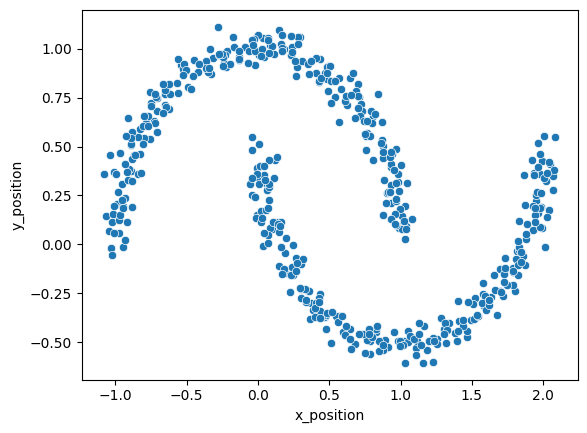

In [3]:
# scenario -> we are trying to analyze pedestrian locations at a specific time in a city square.
# each dot is a person. clustering will help discover natural groups or congested areas
# here we have a true_cluster column. this is actually a label. so this is not a clustering dataset
# it is a classification problem. however we will ignore true_cluster column
# and we will see how we could cluster pedestrians without the true_cluster label as if we didn't have that column
# later on we will use that column to assess whether we dbscan worked or not.
# in a real life scenario, obviously we would need clustering performance metrics like silhoutte to determine the success
df = df.drop("true_cluster", axis=1)
sns.scatterplot(data=df, x="x_position", y="y_position")
plt.show()

In [4]:
df.columns

Index(['x_position', 'y_position'], dtype='object')

In [7]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_scaled=scaler.fit_transform(df)
from sklearn.cluster import DBSCAN
dbscan = DBSCAN()

Parameters
eps : float, default=0.5 The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not a maximum bound on the distances of points within a cluster. This is the most important DBSCAN parameter to choose appropriately for your data set and distance function.

min_samples : int, default=5 The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself. If min_samples is set to a higher value, DBSCAN will find denser clusters, whereas if it is set to a lower value, the found clusters will be more sparse.

In [8]:
dbscan.fit(X_scaled)

DBSCAN()

In [9]:
dbscan.labels_

array([0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,

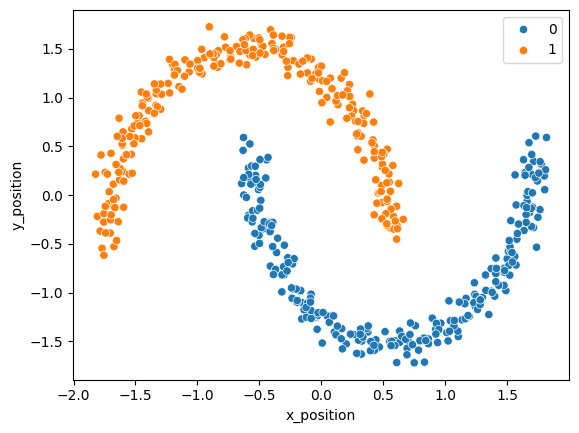

In [10]:
# let's visualize the results
X_scaled = pd.DataFrame(X_scaled, columns = ["x_position", "y_position"])
sns.scatterplot(data=X_scaled, x="x_position", y="y_position", hue=dbscan.labels_)
plt.show()

In [11]:
# let's compare it with the original labels (we do not have this option in a real life case
# but let's just see if it works or not
df = pd.read_csv("24-urban_pedestrian_locations_with_labels.csv")
df.columns

Index(['x_position', 'y_position', 'true_cluster'], dtype='object')

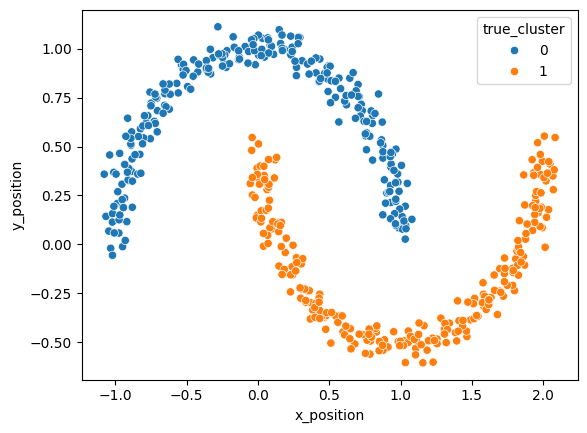

In [12]:
sns.scatterplot(data=df, x="x_position", y="y_position", hue="true_cluster")
plt.show()

In [13]:
# as you can see it produces the same result
# obviously we could be in a situation where we had to perform hyperparameter tuning
# Hyperparameter grids
eps_values = [0.1,0.2,0.3,0.4,0.5,0.6]
min_samples_values = [4,5,6]
from sklearn.metrics import silhouette_score
# Store results
results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
        labels = db.labels_
        # Skip if all points are noise or only one cluster found
        if len(set(labels)) <= 1:
            continue

        silhouette = silhouette_score(X_scaled, labels)

        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'Silhouette': silhouette,
            'n_clusters': len(set(labels)) - (1 if -1 in labels else 0)
        })

# Convert to DataFrame and sort by silhouette
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Silhouette', ascending=False)
results_df

,eps,min_samples,Silhouette,n_clusters
4,0.2,5,0.389338,2
3,0.2,4,0.389338,2
14,0.5,6,0.389338,2
11,0.4,6,0.389338,2
5,0.2,6,0.389338,2
6,0.3,4,0.389338,2
8,0.3,6,0.389338,2
7,0.3,5,0.389338,2
9,0.4,4,0.389338,2
10,0.4,5,0.389338,2


In [14]:
# let's try the same thing with hdbscan, rather than dbscan
from sklearn.cluster import HDBSCAN
hdbscan = HDBSCAN()


min_cluster_size : int, default=5 The minimum number of samples in a group for that group to be considered a cluster; groupings smaller than this size will be left as noise.

min_samples : int, default=None The parameter k used to calculate the distance between a point x_p and its k-th nearest neighbor. When None, defaults to min_cluster_size.


In [15]:
# there is no epsilon in hdbscan as we discussed, so let's try this one without any hyperparameter tuning first
hdbscan.fit(X_scaled)

HDBSCAN()

In [16]:
hdbscan.labels_

array([0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,

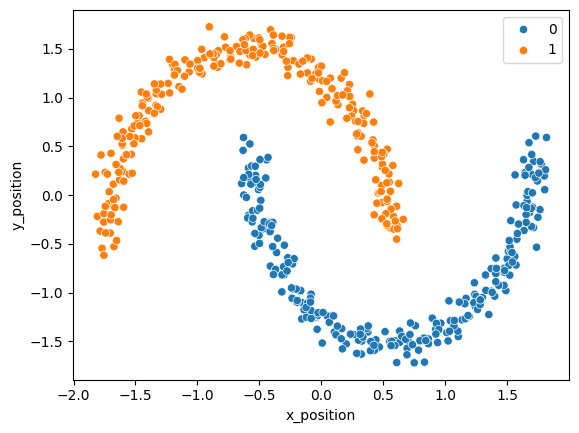

In [17]:
sns.scatterplot(data=X_scaled, x="x_position", y="y_position", hue=hdbscan.labels_)
plt.show()


In [18]:
# as you can see, hdbscan works great as well
# if we had to do hyperparameter tuning, we could have done it in the same way
min_cluster_sizes = [3, 5, 7, 10]
min_samples = [None, 3, 5, 7]
results = []

for min_cluster in min_cluster_sizes:
    for min_sample in min_samples:
        hdb = HDBSCAN(min_cluster_size=min_cluster, min_samples=min_sample).fit(X_scaled)
        labels = hdb.labels_
        # Skip if all points are noise or only one cluster found
        if len(set(labels)) <= 1:
            continue

        silhouette = silhouette_score(X_scaled, labels)

        results.append({
            'min_cluster_size': min_cluster,
            'min_samples': min_sample,
            'Silhouette': silhouette,
            'n_clusters': len(set(labels)) - (1 if -1 in labels else 0)
        })

# Convert to DataFrame and sort by silhouette
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Silhouette', ascending=False)
results_df

,min_cluster_size,min_samples,Silhouette,n_clusters
3,3,7.0,0.389338,2
2,3,5.0,0.389338,2
5,5,3.0,0.389338,2
4,5,NaN,0.389338,2
6,5,5.0,0.389338,2
7,5,7.0,0.389338,2
9,7,3.0,0.389338,2
8,7,NaN,0.389338,2
12,10,NaN,0.389338,2
13,10,3.0,0.389338,2
